## Deep Convolutional Generative Adversarial Network
### author: JiaLing

### 1.(a) Preprocess
|   |   |
|:--:|:--:|
|![GAN_Preprocessing.png](./image/GAN_Preprocessing.png)|![Dummy](./image/Dummy.png)|

Data先經過Resize後，短的那一邊被Resize成指定大小(在本題指定為64pixels),再用CenterCrop切出64×64的影像，在將影像轉換成Tensor之前，將RGB三個通道各別做Normalize到[-1, 1]之間，平均值為0.5。

### 1.(b) learning curve 
- hyper-parameter:
    - learning rate = 0.0002
    - dimension of z domain(nz) = 100
    - number of feature maps in D & G = 64
    - LeakyReLU(0.2): if x<0, then return 0.2 instead of 0(ReLU).
    - Decaying noise: Refer to the exponential decay in 1(c).
    - Label smoothing in both G & D (refer to the range of the value in 1(c))
    
|   | Generated Image | Loss |  |
|:--:|:--:|:--:|:--:|
|![Dummy](image/Dummy.png)|![loss](image/loss.png)|![iter_15500](image/fake_samples_iter_15500.png)|![Dummy](image/Dummy.png)|


### 1.(c)
- Add Decaying noise to training data for G and D

| Real Image w/Decaying Noise | Generated Image | Decaying Noise |
|:--:|:--:|:--:|
|![GIF_real_add_noise](image/Add_noise.gif)|![GIF_fake_add_noise](image/Add_noise_fake.gif)|![PNG_decaying_noise](image\Strategy.png)|

- Add noise scale A

| Generated Image w/noise scale A =0.5|Loss w/ A=0.5|Generated Image w/noise scale A=1|Loss w/ A=1|
|:--:|:--:|:--:|:--:|
|![fake_A0.5](image/fake_samples_iter_8241_A0.5.png)|![loss_A0.5](image/loss_A0.5.png)|![fake_A1](image/fake_samples_iter_8241_A1.png)|![loss_A1](image/loss_A1.png)|

- Label smoothing in G & D (Use Soft and Noisy Labels)  

| (Real, Fake) = (1, 0) | (Real, Fake) = (0.95, 0.15) | (Real, Fake) = ([0.8, 1.1], [0, 0.3]) |
|:--:|:--:|:--:|
|![origin](image\result0_fake_samples_iter_6334.png)|![relabel_fixed](image\relabel_fixed.png)|![relabel_range](image\relabel_range.png)|



### 2.(a) Some questions
![2(a)](image/2(a).png)
- Meaning
    - black dashed line: It is a distribution baed on the real image dataset.
    - x: Domain of real data.
    - z: Domain of sampled noise which will be fed in to the generator.In this case, z is sampled uniformly, but the generator will perform better if z is sampled normally.
- Steps and corresponding objective function
    - Steps(b): D is trained to discriminate between samples from data and from the z domain.
    - Steps(c): G is trained by the guidance from gradient of D , calculated in steps(b).
- The reason why $D(x)$ equals to 0.5 in ideal case when the training is finished
    - It means the discriminator can just guess whether the input image is real or fake, and the generator can successfully fool the discriminator at this time.

### 2.(b) Helvetica Scenario
- Occurance: Placing too much probability mass on a single $x$ is indeed a major problem with GANs. It occurs if we don't train D enough (= we train G too much), then G will quickly "run off" and exploit local minima in D.
- How to avoid it: Do not train G too much without updating the parameters of D, both of them must be equally well with each orher.

### 2.(c) Please compare two results and describe the pros and cons of two models.
|  |Pros|Cons|
|:--:|:--:|:--:|
|VAE| There is a clear and recognized way to evaluate the quality of the model (log-likelihood, either estimated by importance sampling or lower-bounded). | VAE can only generate the images that is similar to images in the training dataset, because VAE models explicitly learn likelihood distribution through loss function. Variational methods introduce deterministic bias because they optimize a lower bound on the log-likelihood. |
|GAN| The images are more creative and real-looking. Cause GAN learns through the so-called “min-max two-player game" to learn likelihood distribution.| Requires finding a Nash equilibrium of a game. It’s hard to do things like guess the value of one pixel given another pixel. |

9th Epoch: 1582/1583, G_loss: 2.0789,  D_loss: 0.885529

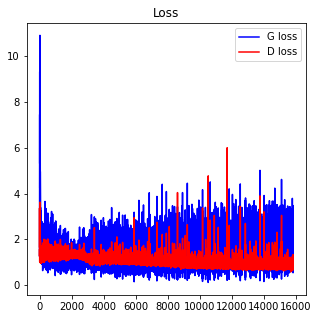

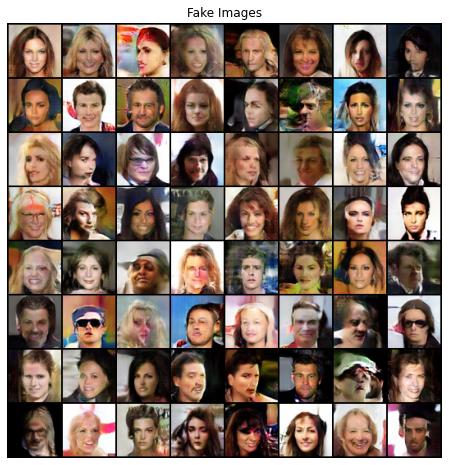

In [2]:
import os, sys
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
import torchvision.utils as vutils

torch.manual_seed(45)
dataroot = "D:/DL_WH3/img_align_celeba/"
out_dir = r'./result'
ngpu = torch.cuda.device_count()
# About data preprocessing 
workers = 1         # Number of workers for dataloader

def plot(G_loss, D_loss, 
    label=['G loss', 'D loss']):

    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(G_loss, 'b', label=label[0])
    ax.plot(D_loss, 'r', label=label[1])
    ax.set_title('Loss')
    ax.legend(loc=1)
    # print(fig.savefig('loss.png', dpi=fig.dpi))
    return fig

def get_mean_std(loader):
    # VAR[X] = E[X**2] - E[X]**2
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    
    for data in loader:
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches +=1
        
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    
    return mean, std

def add_noise2input(input, A, iters, peroid=8000, decay_deg=4):
    # add noise= A*exp(-t/T) in the input data
    if input.is_cuda:   # get boolean if input is in device: cuda
        # if input is in cuda, then use input.device to get the info like this: device(type='cuda', index=0)
        noise = torch.randn_like(input, device=input.device)
    else:
        print("Notice! Your noise tensor isn't in the cuda")
        noise = torch.randn_like(input)
    decay = np.exp(-iters/peroid*decay_deg)
    return input + A*decay*noise
    
# Dataset
class celeba(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.imglist = os.listdir(self.root)

    def __getitem__(self, index):        
        
        img = Image.open(os.path.join(self.root, self.imglist[index]))
        
        if self.transform is not None:
            img = self.transform(img) 
        return img

    def __len__(self):
        return len(self.imglist)
    
def monitor_memory(device):
    if device.type == 'cuda':
        print('Deveice name: ', torch.cuda.get_device_name(0))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

def weights_init(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, args):
        super(Generator, self).__init__()
        nz, ngf, nc = args['nz'], args['ngf'], args['nc']
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, args):
        super(Discriminator, self).__init__()
        ndf, nc = args['ndf'], args['nc']
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# About model
args = {'nc': 3, 
        'nz': 100,
        'ngf': 64,
        'ndf': 64,}
batch_size = 128    # Batch size during training
image_size = 64     # Spatial size of training images. All images will be resized to this size using a transformer.

# About Training setting
num_epochs = 10
lr = 0.0002         # 0.0002 (in DCGAN paper)
beta1 = 0.5         # Beta1 hyperparam for Adam optimizers (in DCGAN paper)

real_label = 0.95
fake_label = 0.15

resume_netG = ''
resume_netD = ''
# Dataset

transform=transforms.Compose([ transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BICUBIC),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                # transforms.Normalize(mean=(0.0157, -0.1563, -0.2474), std=(0.6091, 0.5640, 0.5607))])
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
dataset = celeba(root=dataroot, transform = transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=0)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#Additional Info when using cuda

# real_batch = next(iter(dataloader))
# plt.figure(figsize=(8,8))
# plt.axis("off")
# plt.title("Fake Images")
# plt.imshow(np.transpose(vutils.make_grid(real_gpu.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
# transpose(1,2,0) make data.shape=(3, 64, 64) to (64,64,3)


netG = Generator(args).to(device)
netG.apply(weights_init)
if resume_netG != '':
    netG.load_state_dict(torch.load(resume_netG))
 
netD = Discriminator(args).to(device)
netD.apply(weights_init)
if resume_netD != '':
    netD.load_state_dict(torch.load(resume_netD))

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, args['nz'], 1, 1, device=device)      # for evaluate

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


# Training Loop
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
D_x = []
D_G_z1 = []
D_G_z2 =[]

iters = 0

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        # real_gpu = data.to(device) + torch.randn_like(data, device=device)*0.1    # Fixed noise
        real_gpu = add_noise2input(data.to(device), A=1, iters=iters, peroid=8000, decay_deg=4)    # Decaying noise
        b_size = real_gpu.size(0)
        # plt.imshow(np.transpose(vutils.make_grid(real_gpu.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = label + torch.randn((b_size,), device=device)*0.15
        # Forward pass real batch through D
        output = netD(real_gpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, args['nz'], 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        label = label + torch.randn((b_size,), device=device)*0.15
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake  
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        label = label + torch.randn((b_size,), device=device)*0.15
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)  
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        print(f"\r{epoch}th Epoch: {i}/{len(dataloader)}, G_loss: {format(errG.item(),'2.5')},  D_loss: {format(errD.item(),'2.5')}",end="")
        sys.stdout.flush() 
        iters += 1

plot(G_losses, D_losses)
# torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (out_dir, epoch))
# torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (out_dir, epoch))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(netG(fixed_noise).to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

